In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from multitask.benchmarks.kinetic_models import StereoSelectiveReaction, create_pcs_ds
from summit.utils.multiobjective import pareto_efficient
from summit import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [3]:
#Constants
DATA_PATH   =  '../data/'
SOLVENT_DESCRIPTOR_DATA_FILE =  DATA_PATH + 'solvent_descriptors.csv'
SOLVENT_INDEX = 'cas_number'
SOLVENT_METADATA_VARIABLES = ['stenutz_name', 'cosmo_name', 'chemical_formula']
UCB_PHARMA_APPROVED_LIST = DATA_PATH + 'ucb_pharma_approved_list.csv'
SOLUBILITIES_DATA_FILE = DATA_PATH + "solvent_solubilities.csv"


#Load solvent descriptor dataset
_solvent_candidates = pd.read_csv(SOLVENT_DESCRIPTOR_DATA_FILE)
_solvent_candidates = _solvent_candidates.set_index(SOLVENT_INDEX)
solvent_ds = DataSet.from_df(_solvent_candidates, metadata_columns=SOLVENT_METADATA_VARIABLES)

#Load UCB Pharma approved list
ucb_list = pd.read_csv(UCB_PHARMA_APPROVED_LIST)
ucb_list = ucb_list.set_index('cas_number')
ucb_ds = DataSet.from_df(ucb_list, metadata_columns=['solvent_class', 'solvent_name'])

# Solubilities datset
solubilities = pd.read_csv(SOLUBILITIES_DATA_FILE)
solubilities = solubilities.set_index("cas_number")
solubilities = DataSet.from_df(solubilities)

## Descriptors

In [4]:
solvent_ds_pcs, pca = create_pcs_ds(
    solvent_ds,
    ucb_ds,
    solubilities,
    num_components=3, 
    ucb_filter=True, 
    verbose=True
)

80 solvents for optimization
70% of variance is explained by 3 principal components.


In [5]:
pd.DataFrame(
    pca.components_.T, 
    index=solvent_ds.data_columns + ['solubility'], 
    columns=solvent_ds_pcs.data_columns
).sort_values('PC_1')

,PC_1,PC_2,PC_3
partition_coefficient,-0.350498,-0.012300,0.252559
sigma_2,-0.316189,0.267132,0.074034
molar_volume,-0.295616,0.276469,0.047847
molecular_refractive_power,-0.273993,0.325531,0.106905
molecular_weight,-0.163227,0.390747,0.067756
vapour_pressure,-0.087970,-0.242292,-0.066203
refractive_index,-0.032506,0.205296,0.202902
boiling_point,0.135144,0.408971,0.104810
sigma_5,0.153697,0.300914,-0.261709
viscosity,0.156539,0.147958,0.441249


## Benchmark 

<ipython-input-6-a2e1fe9c44b0>:17: RuntimeWarning: invalid value encountered in true_divide
  axes[1].scatter(trange, cd1/(cd1+cd2)*100, label='de')


Text(0, 0.5, '%')

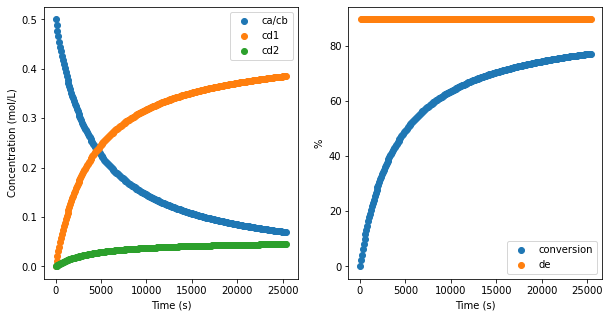

In [6]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(solvent_ds_pcs, random_state)
x = exp._integrate_rate('616-38-6', rxn_time=25200, step_size=100)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
trange = np.linspace(0, 25400, x.shape[0])
cd1 = x[:, 0]
cd2 = x[:, 1]

axes[0].scatter(trange, 0.5-x[:,0]-x[:,1], label='ca/cb')
axes[0].scatter(trange, cd1, label='cd1')
axes[0].scatter(trange, cd2, label='cd2')
axes[0].legend(); axes[0].set_xlabel('Time (s)');
axes[0].set_ylabel('Concentration (mol/L)')

axes[1].scatter(trange, cd1/0.5*100, label='conversion')
axes[1].scatter(trange, cd1/(cd1+cd2)*100, label='de')
axes[1].legend(); axes[1].set_xlabel('Time (s)');
axes[1].set_ylabel('%')

In [7]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(solvent_ds_pcs, random_state)
conditions = DataSet(solvent_ds_pcs.index.values, columns=["solvent"])
all_experiments = exp.run_experiments(conditions) 

In [8]:
all_experiments.sort_values("conversion")

,solvent,conversion,de,computation_t,experiment_t,strategy
36,110-54-3,5.496149,10.233521,0.0,0.023238,NaN
74,540-84-1,30.933193,46.7698,0.0,0.025093,NaN
33,142-82-5,32.142435,48.177143,0.0,0.025187,NaN
0,56-81-5,32.652662,44.998815,0.0,0.029263,NaN
70,111-87-5,43.528419,63.347235,0.0,0.025057,NaN
...,...,...,...,...,...,...
5,96-49-1,79.768892,93.323434,0.0,0.028063,NaN
55,67-64-1,81.040237,89.693131,0.0,0.029093,NaN
65,68-12-2,81.244445,92.247595,0.0,0.027239,NaN
47,126-33-0,81.275079,92.771324,0.0,0.026961,NaN


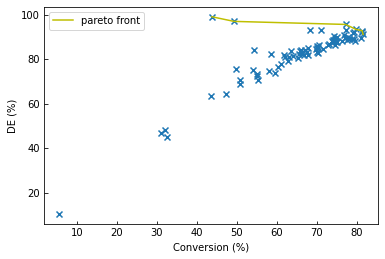

In [9]:
pareto, pareto_indices = pareto_efficient(
    all_experiments[["conversion", "de"]].to_numpy()
)
pareto = pd.DataFrame(pareto).sort_values(0).to_numpy()
ax = plt.subplot(111)
ax.set_xlabel('Conversion (%)'); ax.set_ylabel('DE (%)')
ax.scatter(all_experiments["conversion"], all_experiments["de"], marker='x')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front')
ax.legend()
ax.tick_params(direction='in')
# plt.savefig('outputs/solvent_optimization_experiment_space.png')
# plt.savefig('outputs/solvent_optimization_experiment_space.svg')

## Optimization

In [10]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(
    solvent_ds_pcs.iloc[:50], random_state, use_descriptors=False
)
strategy = TSEMO(exp.domain, n_spectral_points=100)
r = Runner(strategy=strategy, experiment=exp, max_iterations=10, batch_size=10)
r.run()

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/summit/experiment.py:234: UserWarning:No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: xlabel='conversion', ylabel='de'>)

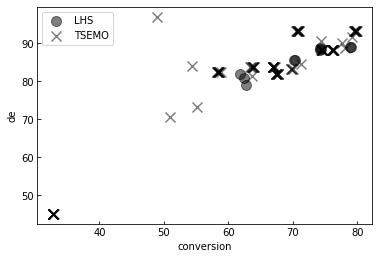

In [12]:
r.experiment.pareto_plot()